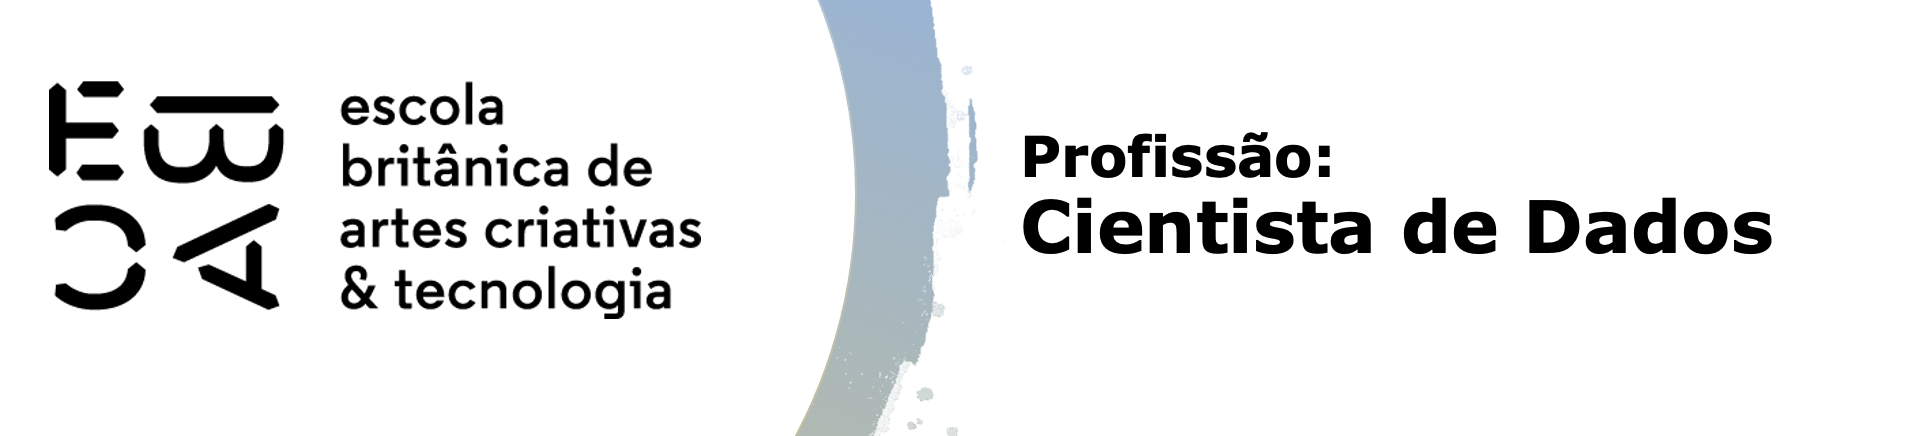

# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [24]:
# Importar bibliotecas
import pandas as pd

# Definir os caminhos das bases de dados
dataset_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/UCI HAR Dataset/'
csv_path = r'C:/Users/conta/OneDrive/Área de Trabalho/PAULO/Ciência de Dados/EBAC/Aulas/Arvores II/'

# Carregar as bases de dados com o parâmetro atualizado
Y_train = pd.read_csv(dataset_path + 'train/y_train.txt', header=None, names=["activity"], sep=r'\s+').squeeze()
Y_test = pd.read_csv(dataset_path + 'test/y_test.txt', header=None, names=["activity"], sep=r'\s+').squeeze()

# Carregar X_train e X_test como anteriormente
X_train = pd.read_csv(csv_path + 'X_train_subset.csv', index_col=[0, 1])
X_test = pd.read_csv(csv_path + 'X_test_subset.csv', index_col=[0, 1])



### 2. Calcule os ```ccp_alphas```. 

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

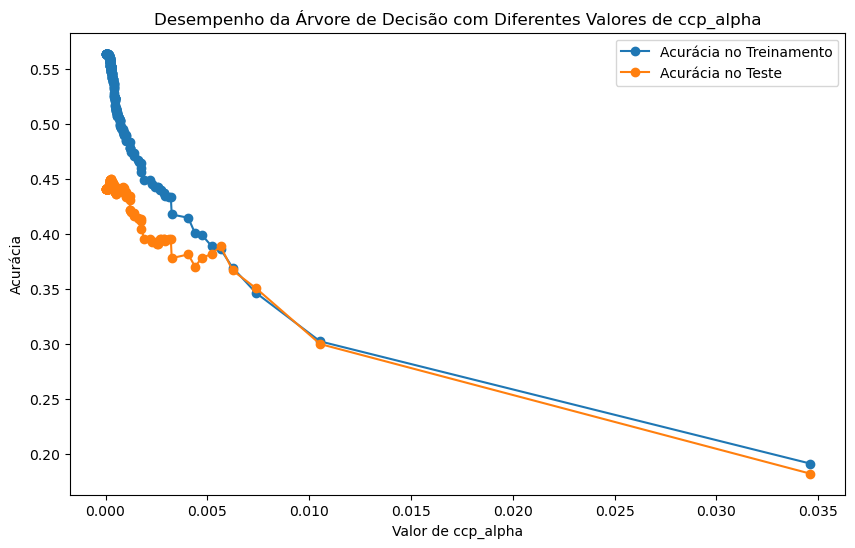

In [28]:
import matplotlib.pyplot as plt  # Adicione esta linha no início do código

# Calculando os valores de ccp_alpha usando o custo de complexidade de poda
path = DecisionTreeClassifier(random_state=42, min_samples_leaf=20).fit(X_train, Y_train).cost_complexity_pruning_path(X_train, Y_train)
ccp_alphas = path.ccp_alphas  # Esse é o array que contém os valores de ccp_alpha

train_scores = []
test_scores = []

# Para cada valor de ccp_alpha, treinar o modelo e calcular a acurácia
for ccp in ccp_alphas:
    model = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp, min_samples_leaf=20)
    model.fit(X_train, Y_train)
    
    # Calculando as acurácias nos conjuntos de treino e teste
    train_scores.append(model.score(X_train, Y_train))
    test_scores.append(model.score(X_test, Y_test))

# Plotando a acurácia para treino e teste
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, label="Acurácia no Treinamento", marker="o")
plt.plot(ccp_alphas, test_scores, label="Acurácia no Teste", marker="o")
plt.xlabel("Valor de ccp_alpha")
plt.ylabel("Acurácia")
plt.title("Desempenho da Árvore de Decisão com Diferentes Valores de ccp_alpha")
plt.legend()
plt.show()


### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [32]:
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Calcular ccp_alpha
model = DecisionTreeClassifier(random_state=42)
path = model.cost_complexity_pruning_path(X_train, Y_train)  # Usando X_train e Y_train
ccp_alphas = path.ccp_alphas

# Limitar a 1 valor a cada 10 valores de ccp_alpha (para uma melhor varredura)
ccp_alphas_subset = ccp_alphas[::10]

# Definir o GridSearchCV com validação cruzada k-fold (k=10)
param_grid = {'ccp_alpha': ccp_alphas_subset}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=10)

# Medir o tempo de execução
start_time = time.time()

# Ajustar o modelo
grid.fit(X_train, Y_train)

# Verificar o melhor modelo encontrado
best_model = grid.best_estimator_

# Tempo de execução
end_time = time.time()
execution_time = end_time - start_time

# Resultados
print(f"Melhor modelo encontrado: {best_model}")
print(f"Melhor ccp_alpha: {grid.best_params_['ccp_alpha']}")
print(f"Tempo de execução: {execution_time:.2f} segundos")


Melhor modelo encontrado: DecisionTreeClassifier(ccp_alpha=0.0005832731672844108, random_state=42)
Melhor ccp_alpha: 0.0005832731672844108
Tempo de execução: 139.67 segundos


### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia total: 0.3699


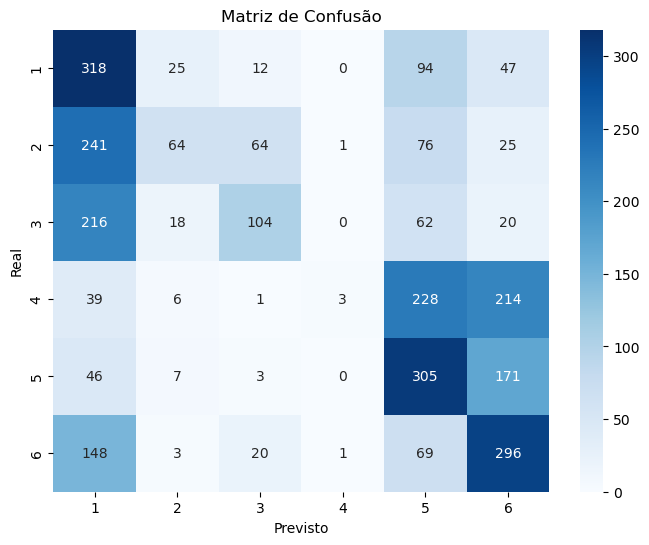

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Treinar a árvore com toda a base de treino
best_model = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, max_depth=4)
best_model.fit(X_train, Y_train)

# Fazer previsões na base de teste
y_pred = best_model.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(Y_test, y_pred)
print(f'Acurácia total: {accuracy:.4f}')

# Gerar a matriz de confusão
cm = confusion_matrix(Y_test, y_pred)

# Exibir a matriz de confusão de forma visual
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()


### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd

# Identificar a classe com maior erro
cm = confusion_matrix(Y_test, best_model.predict(X_test))  # Garantindo matriz 6x6
erro_classes = cm.sum(axis=1) - cm.diagonal()
maior_erro_class = erro_classes.argmax()

# Criar variável binária para a classe de maior erro
Y_train_erro = (Y_train == maior_erro_class).astype(int)
Y_test_erro = (Y_test == maior_erro_class).astype(int)

# Treinar árvore simples com todas as variáveis
clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=20, max_depth=4)
clf.fit(X_train, Y_train_erro)

# Obter as 3 variáveis mais importantes
var_new = pd.DataFrame(X_train.columns, columns=["Variável"])
var_new["importances"] = clf.feature_importances_
var_new = var_new.sort_values(by="importances", ascending=False)[:3]

# Selecionar as novas variáveis
X_train_ex5 = X_train[var_new["Variável"]]
X_test_ex5 = X_test[var_new["Variável"]]

# Re-treinar o modelo com as 3 variáveis mais importantes
grid.fit(X_train_ex5, Y_train)
best_model = grid.best_estimator_

# Predições e avaliação
y_pred = best_model.predict(X_test_ex5)

# Matriz de Confusão (mantendo 6x6)
cm = confusion_matrix(Y_test, y_pred)
print("Matriz de Confusão:")
print(cm)

# Avaliar a acurácia por classe
for i in range(len(cm)):
    print(f"Classe {best_model.classes_[i]}: {cm[i, i] / cm.sum(axis=1)[i]}")

# Exibir a acurácia total
accuracy = accuracy_score(Y_test, y_pred)
print(f'Acurácia total: {accuracy}')

